In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, CustomWrapper, LWRBoost

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#set up some stuff to manage metadata for each dataset
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }


In [3]:
#setup input and output formats, load data

file_name = "PLN7.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)



data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path("D:/workspace/lazydeep/experiments/1.07")
n_components = 34

data_file = data_path / file_name
log_dir = log_path / dataset_name
model_dir = model_path / dataset_name

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

id_cols =id_col_db[dataset_name]
output_cols = output_col_db[dataset_name]


D:\workspace\lazydeep\experiments\1.07\PLN7


In [4]:
data = pd.read_csv(data_file)
if not file_name == 'mango_684_990.csv': 
    data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
#dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)


In [5]:
n_models = 100

model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")

#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [6]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")

In [7]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = PLSRegression(n_components=n_components)

if dataset_name == 'mango_684_990':
    eval_ = MangoesSplitter(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
else:
    eval_ = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
    
print(f"Dataset shape is {data.shape}")
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = None #lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = None #lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

Dataset shape is (10000, 129)


In [8]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval_.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval_.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    
all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Tested (test) on 1667 instances with mean losses of: random_0:147.1446,random_1:161.1235,random_2:148.0153,random_3:2762.2158,random_4:149.5205,random_5:134.669,random_6:466.0829,random_7:151.6422,random_8:151.2387,random_9:310.3846,random_10:146.2283,random_11:152.8767,random_12:166.4905,random_13:684.0451,random_14:137.7049,random_15:156.9714,random_16:169.3578,random_17:144.9467,random_18:159.2038,random_19:166.2787,random_20:152.0457,random_21:182.3562,random_22:175.5737,random_23:181.1456,random_24:144.4135,random_25:155.3511,random_26:466.1744,random_27:224.4122,random_28:142.8462,random_29:154.4464,random_30:173.3534,random_31:1270.8496,random_32:152.9794,random_33:160.7083,random_34:154.5682,random_35:465.9934,random_36:142.6404,random_37:166.6472,random_38:162.0285,random_39:164.3657,random_40:153.9292,random_41:155.9942,rando

In [9]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
n = 30
best_n = []
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)
    if i < n:
        best_n.append(row['model_num'])

0 - random_82 - deep - 137.5075182648712 - 130.4421176006498 - 144.06449480977827 - 127.65992345271849 - 131.84387805109836 - 134.30467871071176 - 0.7199893993454223
1 - random_24 - deep - 144.41353603516356 - 132.81591498472767 - 145.4006378800839 - 121.6521948073663 - 130.38346345313028 - 134.9352893915091 - 0.7186746448841157
2 - random_10 - deep - 146.22829733827405 - 131.2531475577443 - 142.54620770487017 - 119.59081962557973 - 137.4023663176208 - 135.40582546692042 - 0.7176936285087342
3 - random_4 - deep - 149.52052070283574 - 139.50407097535572 - 143.93053564656333 - 124.70355024944548 - 135.62736985663406 - 138.6592477281742 - 0.7109105980863994
4 - random_73 - deep - 143.369752692833 - 138.57852169190184 - 150.11264153991405 - 130.9745516782763 - 134.5115186226468 - 139.51102111677213 - 0.7091347435111719
5 - random_94 - deep - 147.74845175007968 - 133.9410871426789 - 150.27850711595963 - 128.0872647581982 - 142.83391092032517 - 140.57907244776365 - 0.7069079730249028
6 - ran

In [10]:
def build_predictors(n,deep):
    predictors = {}
    for i in [100,500,1000]:
        if i* 2 < n:
            predictors[f'knn_tta_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='additive',reverse=True)
            predictors[f'knn_ttm_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='multiplicative',reverse=True)
            predictors[f'knn_tta_r_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='additive',reverse=False)
            predictors[f'knn_ttm_r_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='multiplicative',reverse=False)
    return predictors


deep_models = {k:v for k,v in deep_models.items() if k in best_n}
for deep_name,deep_model in tqdm(deep_models.items()):
    #if #int(deep_name.replace("random_","")) >=34 :
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = BoostScheme(boost_models = build_predictors(nrow,deep_model),loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval_.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log")
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval_.build(temp_dict,dataset,lwr_scheme,logger_name="test_log")

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items(): 
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)


  0%|          | 0/30 [00:00<?, ?it/s]

Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:124.1964,knn_ttm_n=100:116.1614,knn_tta_r_n=100:138.6778,knn_ttm_r_n=100:138.1299,knn_tta_n=500:198.6792,knn_ttm_n=500:208.1391,knn_tta_r_n=500:205.8835,knn_ttm_r_n=500:200.6888,knn_tta_n=1000:217.6973,knn_ttm_n=1000:230.605,knn_tta_r_n=1000:223.2779,knn_ttm_r_n=1000:219.0237'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:1333604.3491,knn_ttm_n=100:2703754.5602,knn_tta_r_n=100:1225055.8844,knn_ttm_r_n=100:8473619.1789,knn_tta_n=500:250309.4263,knn_ttm_n=500:376125.1873,knn_tta_r_n=500:189048.9805,knn_ttm_r_n=500:182232.2327,knn_tta_n=1000:584.5302,knn_ttm_n=1000:735.9487,knn_tta_r_n=1000:414.1572,knn_ttm_r_n=1000:848.3392'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667--------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:72.7425,knn_ttm_n=100:67.3145,knn_tta_r_n=100:87.8826,knn_ttm_r_n=100:95.1033,knn_tta_n=500:157.7717,knn_ttm_n=500:162.5598,knn_tta_r_n=500:165.9128,knn_ttm_r_n=500:156.3374,knn_tta_n=1000:176.8232,knn_ttm_n=1000:190.4279,knn_tta_r_n=1000:180.8135,knn_ttm_r_n=1000:178.2719'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:520.3509,knn_ttm_n=100:621.576,knn_tta_r_n=100:350.335,knn_ttm_r_n=100:399.0087,knn_tta_n=500:230.0105,knn_ttm_n=500:266.2484,knn_tta_r_n=500:216.9917,knn_ttm_r_n=500:221.4987,knn_tta_n=1000:218.8333,knn_ttm_n=1000:244.9171,knn_tta_r_n=1000:214.0827,knn_ttm_r_n=1000:217.8792'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boos

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:232.1807,knn_ttm_n=100:240.6178,knn_tta_r_n=100:234.725,knn_ttm_r_n=100:268.3134,knn_tta_n=500:253.5245,knn_ttm_n=500:268.8097,knn_tta_r_n=500:255.5569,knn_ttm_r_n=500:255.3094,knn_tta_n=1000:257.3748,knn_ttm_n=1000:274.1111,knn_tta_r_n=1000:259.6885,knn_ttm_r_n=1000:259.0429'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:324.4585,knn_ttm_n=100:615.778,knn_tta_r_n=100:334.3331,knn_ttm_r_n=100:301.5312,knn_tta_n=500:277.2918,knn_ttm_n=500:297.3798,knn_tta_r_n=500:278.6674,knn_ttm_r_n=500:280.5094,knn_tta_n=1000:279.9174,knn_ttm_n=1000:298.1805,knn_tta_r_n=1000:282.2892,knn_ttm_r_n=1000:282.2632'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:174.1281,knn_ttm_n=100:167.5205,knn_tta_r_n=100:185.922,knn_ttm_r_n=100:175.2998,knn_tta_n=500:237.5072,knn_ttm_n=500:259.3698,knn_tta_r_n=500:241.1026,knn_ttm_r_n=500:238.4506,knn_tta_n=1000:250.4873,knn_ttm_n=1000:280.8861,knn_tta_r_n=1000:251.7809,knn_ttm_r_n=1000:251.152'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:322.5988,knn_ttm_n=100:388.6524,knn_tta_r_n=100:283.226,knn_ttm_r_n=100:291.6085,knn_tta_n=500:299.1263,knn_ttm_n=500:336.3594,knn_tta_r_n=500:280.9305,knn_ttm_r_n=500:280.6803,knn_tta_n=1000:302.0341,knn_ttm_n=1000:345.731,knn_tta_r_n=1000:289.2623,knn_ttm_r_n=1000:286.9294'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:53.5949,knn_ttm_n=100:41.34,knn_tta_r_n=100:70.3487,knn_ttm_r_n=100:47.2375,knn_tta_n=500:129.6445,knn_ttm_n=500:118.6824,knn_tta_r_n=500:143.9069,knn_ttm_r_n=500:121.3565,knn_tta_n=1000:150.9739,knn_ttm_n=1000:146.0585,knn_tta_r_n=1000:162.5054,knn_ttm_r_n=1000:145.8759'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:255.3146,knn_ttm_n=100:329.5147,knn_tta_r_n=100:204.2617,knn_ttm_r_n=100:217.9668,knn_tta_n=500:189.8609,knn_ttm_n=500:216.1223,knn_tta_r_n=500:187.7145,knn_ttm_r_n=500:189.4621,knn_tta_n=1000:193.1247,knn_ttm_n=1000:209.6567,knn_tta_r_n=1000:195.6459,knn_ttm_r_n=1000:191.6257'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:97.4675,knn_ttm_n=100:75.6139,knn_tta_r_n=100:114.9171,knn_ttm_r_n=100:91.3316,knn_tta_n=500:159.3347,knn_ttm_n=500:148.9428,knn_tta_r_n=500:170.4991,knn_ttm_r_n=500:156.4121,knn_tta_n=1000:175.384,knn_ttm_n=1000:171.6472,knn_tta_r_n=1000:185.8242,knn_ttm_r_n=1000:175.6569'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:224.6736,knn_ttm_n=100:269.6321,knn_tta_r_n=100:205.2817,knn_ttm_r_n=100:209.7761,knn_tta_n=500:209.1736,knn_ttm_n=500:229.7086,knn_tta_r_n=500:208.0399,knn_ttm_r_n=500:208.7956,knn_tta_n=1000:208.7963,knn_ttm_n=1000:225.8515,knn_tta_r_n=1000:214.2584,knn_ttm_r_n=1000:214.0781'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:128.6433,knn_ttm_n=100:122.2185,knn_tta_r_n=100:142.4218,knn_ttm_r_n=100:143.7717,knn_tta_n=500:210.8188,knn_ttm_n=500:229.4676,knn_tta_r_n=500:214.5114,knn_ttm_r_n=500:210.9733,knn_tta_n=1000:223.1517,knn_ttm_n=1000:243.964,knn_tta_r_n=1000:226.5384,knn_ttm_r_n=1000:246.0735'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:614.472,knn_ttm_n=100:575.3651,knn_tta_r_n=100:527.9105,knn_ttm_r_n=100:600.6154,knn_tta_n=500:296.9736,knn_ttm_n=500:338.7356,knn_tta_r_n=500:278.73,knn_ttm_r_n=500:273.6061,knn_tta_n=1000:283.9284,knn_ttm_n=1000:322.7446,knn_tta_r_n=1000:273.7349,knn_ttm_r_n=1000:273.4479'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:209.258,knn_ttm_n=100:254.9808,knn_tta_r_n=100:204.3597,knn_ttm_r_n=100:203.8794,knn_tta_n=500:242.6632,knn_ttm_n=500:275.1742,knn_tta_r_n=500:242.9072,knn_ttm_r_n=500:242.5602,knn_tta_n=1000:251.9478,knn_ttm_n=1000:279.4853,knn_tta_r_n=1000:252.3396,knn_ttm_r_n=1000:252.4282'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:114581.0278,knn_ttm_n=100:7648.2433,knn_tta_r_n=100:236219.4271,knn_ttm_r_n=100:1580301.3079,knn_tta_n=500:443.3044,knn_ttm_n=500:562.2334,knn_tta_r_n=500:341.9879,knn_ttm_r_n=500:330.5884,knn_tta_n=1000:441.9194,knn_ttm_n=1000:545.6744,knn_tta_r_n=1000:346.2857,knn_ttm_r_n=1000:334.0097'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finis

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:143.759,knn_ttm_n=100:117.4291,knn_tta_r_n=100:157.4858,knn_ttm_r_n=100:138.236,knn_tta_n=500:189.7588,knn_ttm_n=500:186.3409,knn_tta_r_n=500:195.6565,knn_ttm_r_n=500:184.6221,knn_tta_n=1000:202.3321,knn_ttm_n=1000:207.4674,knn_tta_r_n=1000:207.101,knn_ttm_r_n=1000:197.5733'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:245.3034,knn_ttm_n=100:288.2721,knn_tta_r_n=100:226.1996,knn_ttm_r_n=100:235.0094,knn_tta_n=500:234.7541,knn_ttm_n=500:255.8778,knn_tta_r_n=500:228.5251,knn_ttm_r_n=500:226.8898,knn_tta_n=1000:235.7786,knn_ttm_n=1000:253.9017,knn_tta_r_n=1000:233.0724,knn_ttm_r_n=1000:230.1709'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:291.7509,knn_ttm_n=100:295.8908,knn_tta_r_n=100:278.5365,knn_ttm_r_n=100:278.0275,knn_tta_n=500:296.7792,knn_ttm_n=500:5672994.8877,knn_tta_r_n=500:284.7369,knn_ttm_r_n=500:5672981.501,knn_tta_n=1000:284.0935,knn_ttm_n=1000:313.1623,knn_tta_r_n=1000:286.1727,knn_ttm_r_n=1000:287.5656'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:344.5164,knn_ttm_n=100:357.8928,knn_tta_r_n=100:321.4963,knn_ttm_r_n=100:327.1978,knn_tta_n=500:328.1636,knn_ttm_n=500:5084352.2526,knn_tta_r_n=500:316.5501,knn_ttm_r_n=500:5084345.7538,knn_tta_n=1000:312.8336,knn_ttm_n=1000:337.3494,knn_tta_r_n=1000:316.7021,knn_ttm_r_n=1000:318.8743'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:136.5888,knn_ttm_n=100:115.9961,knn_tta_r_n=100:151.1797,knn_ttm_r_n=100:130.3946,knn_tta_n=500:185.8459,knn_ttm_n=500:189.7075,knn_tta_r_n=500:193.8351,knn_ttm_r_n=500:182.6834,knn_tta_n=1000:199.3686,knn_ttm_n=1000:209.9173,knn_tta_r_n=1000:205.7686,knn_ttm_r_n=1000:197.741'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:263.9354,knn_ttm_n=100:322.2798,knn_tta_r_n=100:225.2945,knn_ttm_r_n=100:234.0893,knn_tta_n=500:438.8118,knn_ttm_n=500:450.5375,knn_tta_r_n=500:267.2711,knn_ttm_r_n=500:249.0383,knn_tta_n=1000:233.5556,knn_ttm_n=1000:263.9707,knn_tta_r_n=1000:227.6757,knn_ttm_r_n=1000:225.4999'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished trainin

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:256.747,knn_ttm_n=100:275.5548,knn_tta_r_n=100:258.1693,knn_ttm_r_n=100:261.4506,knn_tta_n=500:270.5036,knn_ttm_n=500:289.8135,knn_tta_r_n=500:270.1378,knn_ttm_r_n=500:270.8844,knn_tta_n=1000:272.4437,knn_ttm_n=1000:293.2128,knn_tta_r_n=1000:272.0243,knn_ttm_r_n=1000:273.0061'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:310.1287,knn_ttm_n=100:348.207,knn_tta_r_n=100:298.9954,knn_ttm_r_n=100:298.8502,knn_tta_n=500:299.0404,knn_ttm_n=500:325.014,knn_tta_r_n=500:296.3432,knn_ttm_r_n=500:297.1968,knn_tta_n=1000:298.7965,knn_ttm_n=1000:322.4027,knn_tta_r_n=1000:296.8731,knn_ttm_r_n=1000:297.8445'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:123.7022,knn_ttm_n=100:107.5254,knn_tta_r_n=100:139.0404,knn_ttm_r_n=100:120.712,knn_tta_n=500:185.4839,knn_ttm_n=500:184.9839,knn_tta_r_n=500:194.5146,knn_ttm_r_n=500:182.23,knn_tta_n=1000:200.2559,knn_ttm_n=1000:205.2153,knn_tta_r_n=1000:207.4111,knn_ttm_r_n=1000:199.1771'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:289.1916,knn_ttm_n=100:470.8966,knn_tta_r_n=100:252.2545,knn_ttm_r_n=100:293.1889,knn_tta_n=500:252.4221,knn_ttm_n=500:286.4807,knn_tta_r_n=500:248.8395,knn_ttm_r_n=500:249.1583,knn_tta_n=1000:238.7887,knn_ttm_n=1000:267.1716,knn_tta_r_n=1000:235.5954,knn_ttm_r_n=1000:236.6849'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:168.8975,knn_ttm_n=100:194.6244,knn_tta_r_n=100:157.5783,knn_ttm_r_n=100:198.6873,knn_tta_n=500:190.4317,knn_ttm_n=500:221.2152,knn_tta_r_n=500:187.8912,knn_ttm_r_n=500:979.0134,knn_tta_n=1000:198.2262,knn_ttm_n=1000:223.2108,knn_tta_r_n=1000:196.9801,knn_ttm_r_n=1000:251.8594'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:1141.0554,knn_ttm_n=100:2871.721,knn_tta_r_n=100:670.4125,knn_ttm_r_n=100:757.6708,knn_tta_n=500:270.4014,knn_ttm_n=500:345.6993,knn_tta_r_n=500:242.7539,knn_ttm_r_n=500:260.088,knn_tta_n=1000:276.9828,knn_ttm_n=1000:305.1904,knn_tta_r_n=1000:238.4317,knn_ttm_r_n=1000:260.3207'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished traini

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:296.1422,knn_ttm_n=100:304.5391,knn_tta_r_n=100:288.5327,knn_ttm_r_n=100:303.1133,knn_tta_n=500:291.921,knn_ttm_n=500:319.0673,knn_tta_r_n=500:290.792,knn_ttm_r_n=500:302.1243,knn_tta_n=1000:291.5801,knn_ttm_n=1000:318.717,knn_tta_r_n=1000:291.2523,knn_ttm_r_n=1000:302.3366'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:335.6214,knn_ttm_n=100:340.8823,knn_tta_r_n=100:318.5239,knn_ttm_r_n=100:319.6725,knn_tta_n=500:320.2362,knn_ttm_n=500:350.806,knn_tta_r_n=500:317.7276,knn_ttm_r_n=500:319.2912,knn_tta_n=1000:315.536,knn_ttm_n=1000:345.3256,knn_tta_r_n=1000:314.7534,knn_ttm_r_n=1000:315.6401'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Bo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:396.2995,knn_ttm_n=100:558.0814,knn_tta_r_n=100:254.384,knn_ttm_r_n=100:23769333.3718,knn_tta_n=500:249.276,knn_ttm_n=500:273.836,knn_tta_r_n=500:248.4355,knn_ttm_r_n=500:1897.5731,knn_tta_n=1000:252.4653,knn_ttm_n=1000:273.0348,knn_tta_r_n=1000:254.2219,knn_ttm_r_n=1000:254.7912'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:128506349.2331,knn_ttm_n=100:518189765.8877,knn_tta_r_n=100:202811090.4642,knn_ttm_r_n=100:262489080.9235,knn_tta_n=500:355.0845,knn_ttm_n=500:533.6998,knn_tta_r_n=500:316.5764,knn_ttm_r_n=500:316.4149,knn_tta_n=1000:318.4159,knn_ttm_n=1000:422.1568,knn_tta_r_n=1000:305.7998,knn_ttm_r_n=1000:303.5252'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:227.2763,knn_ttm_n=100:212.149,knn_tta_r_n=100:145.286,knn_ttm_r_n=100:902.0256,knn_tta_n=500:247.4974,knn_ttm_n=500:291.0668,knn_tta_r_n=500:218.5908,knn_ttm_r_n=500:199.4818,knn_tta_n=1000:296.5695,knn_ttm_n=1000:373.6415,knn_tta_r_n=1000:238.9464,knn_ttm_r_n=1000:228.0204'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:2894538.4187,knn_ttm_n=100:4535024.3453,knn_tta_r_n=100:1601758.6561,knn_ttm_r_n=100:1160878.891,knn_tta_n=500:436.7776,knn_ttm_n=500:499.5798,knn_tta_r_n=500:258.2355,knn_ttm_r_n=500:247.892,knn_tta_n=1000:348.0028,knn_ttm_n=1000:377.3691,knn_tta_r_n=1000:288.1555,knn_ttm_r_n=1000:269.4977'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Fin

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:181.4653,knn_ttm_n=100:159.1421,knn_tta_r_n=100:194.6336,knn_ttm_r_n=100:177.2383,knn_tta_n=500:218.5805,knn_ttm_n=500:225.0958,knn_tta_r_n=500:229.0634,knn_ttm_r_n=500:219.0558,knn_tta_n=1000:232.3504,knn_ttm_n=1000:243.45,knn_tta_r_n=1000:241.0553,knn_ttm_r_n=1000:233.3665'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:300.1763,knn_ttm_n=100:1139.704,knn_tta_r_n=100:271.3467,knn_ttm_r_n=100:1053.9784,knn_tta_n=500:264.686,knn_ttm_n=500:293.8603,knn_tta_r_n=500:262.0203,knn_ttm_r_n=500:262.1209,knn_tta_n=1000:269.8846,knn_ttm_n=1000:295.7251,knn_tta_r_n=1000:269.609,knn_ttm_r_n=1000:266.3592'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:99.9885,knn_ttm_n=100:82.8572,knn_tta_r_n=100:116.2095,knn_ttm_r_n=100:94.9633,knn_tta_n=500:183.0945,knn_ttm_n=500:188.3857,knn_tta_r_n=500:190.2859,knn_ttm_r_n=500:176.535,knn_tta_n=1000:203.6531,knn_ttm_n=1000:220.2192,knn_tta_r_n=1000:208.2865,knn_ttm_r_n=1000:202.3761'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:508.936,knn_ttm_n=100:628.0877,knn_tta_r_n=100:330.9703,knn_ttm_r_n=100:342.5767,knn_tta_n=500:270.4439,knn_ttm_n=500:307.2008,knn_tta_r_n=500:248.4235,knn_ttm_r_n=500:255.3264,knn_tta_n=1000:251.7291,knn_ttm_n=1000:283.7052,knn_tta_r_n=1000:246.4116,knn_ttm_r_n=1000:247.4561'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Bo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:120.5988,knn_ttm_n=100:113.1024,knn_tta_r_n=100:135.1086,knn_ttm_r_n=100:137.9645,knn_tta_n=500:183.8137,knn_ttm_n=500:191.0834,knn_tta_r_n=500:191.1908,knn_ttm_r_n=500:196.5195,knn_tta_n=1000:199.3644,knn_ttm_n=1000:211.8954,knn_tta_r_n=1000:204.7046,knn_ttm_r_n=1000:201.2486'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:319.4578,knn_ttm_n=100:457.2342,knn_tta_r_n=100:277.4381,knn_ttm_r_n=100:372.5107,knn_tta_n=500:230.1355,knn_ttm_n=500:262.6251,knn_tta_r_n=500:222.033,knn_ttm_r_n=500:225.2397,knn_tta_n=1000:228.0577,knn_ttm_n=1000:257.0719,knn_tta_r_n=1000:227.6117,knn_ttm_r_n=1000:227.4133'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished trainin

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:133.3673,knn_ttm_n=100:105.1808,knn_tta_r_n=100:153.054,knn_ttm_r_n=100:131.1846,knn_tta_n=500:202.6021,knn_ttm_n=500:198.6864,knn_tta_r_n=500:215.3381,knn_ttm_r_n=500:201.8935,knn_tta_n=1000:221.8512,knn_ttm_n=1000:227.4901,knn_tta_r_n=1000:232.4949,knn_ttm_r_n=1000:221.3672'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:293.0261,knn_ttm_n=100:355.6661,knn_tta_r_n=100:245.8741,knn_ttm_r_n=100:248.8129,knn_tta_n=500:254.8186,knn_ttm_n=500:278.6458,knn_tta_r_n=500:243.6875,knn_ttm_r_n=500:241.9608,knn_tta_n=1000:251.5635,knn_ttm_n=1000:279.6348,knn_tta_r_n=1000:250.4995,knn_ttm_r_n=1000:247.6124'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished trainin

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:106.1026,knn_ttm_n=100:87.4209,knn_tta_r_n=100:120.2677,knn_ttm_r_n=100:98.8091,knn_tta_n=500:176.4026,knn_ttm_n=500:181.9133,knn_tta_r_n=500:179.3285,knn_ttm_r_n=500:168.3872,knn_tta_n=1000:192.2165,knn_ttm_n=1000:206.4332,knn_tta_r_n=1000:193.6495,knn_ttm_r_n=1000:187.3013'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:332.2067,knn_ttm_n=100:423.7463,knn_tta_r_n=100:264.0136,knn_ttm_r_n=100:299.4413,knn_tta_n=500:236.4876,knn_ttm_n=500:262.2427,knn_tta_r_n=500:227.4981,knn_ttm_r_n=500:225.493,knn_tta_n=1000:235.803,knn_ttm_n=1000:262.2926,knn_tta_r_n=1000:229.9557,knn_ttm_r_n=1000:229.6633'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:146.6022,knn_ttm_n=100:129.3252,knn_tta_r_n=100:159.213,knn_ttm_r_n=100:216.8509,knn_tta_n=500:206.5101,knn_ttm_n=500:220.9052,knn_tta_r_n=500:209.8034,knn_ttm_r_n=500:204.5406,knn_tta_n=1000:221.1294,knn_ttm_n=1000:243.2057,knn_tta_r_n=1000:223.1227,knn_ttm_r_n=1000:220.8997'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:686.1702,knn_ttm_n=100:882.1532,knn_tta_r_n=100:428.3721,knn_ttm_r_n=100:501.266,knn_tta_n=500:255.5987,knn_ttm_n=500:286.7365,knn_tta_r_n=500:244.1108,knn_ttm_r_n=500:243.8415,knn_tta_n=1000:252.7562,knn_ttm_n=1000:278.8653,knn_tta_r_n=1000:249.987,knn_ttm_r_n=1000:249.333'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:240.5972,knn_ttm_n=100:262.9296,knn_tta_r_n=100:242.8676,knn_ttm_r_n=100:246.7374,knn_tta_n=500:262.8673,knn_ttm_n=500:286.3165,knn_tta_r_n=500:263.4357,knn_ttm_r_n=500:264.6267,knn_tta_n=1000:266.7348,knn_ttm_n=1000:290.7922,knn_tta_r_n=1000:268.33,knn_ttm_r_n=1000:268.4017'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:309.1336,knn_ttm_n=100:368.4312,knn_tta_r_n=100:293.7362,knn_ttm_r_n=100:295.6631,knn_tta_n=500:286.4611,knn_ttm_n=500:315.3385,knn_tta_r_n=500:286.5283,knn_ttm_r_n=500:289.3675,knn_tta_n=1000:286.3663,knn_ttm_n=1000:308.4463,knn_tta_r_n=1000:289.7552,knn_ttm_r_n=1000:291.0632'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:197.7954,knn_ttm_n=100:279.9599,knn_tta_r_n=100:188.3159,knn_ttm_r_n=100:10066.9965,knn_tta_n=500:232.5142,knn_ttm_n=500:345.7973,knn_tta_r_n=500:217.8966,knn_ttm_r_n=500:219.3281,knn_tta_n=1000:329.3743,knn_ttm_n=1000:283.8919,knn_tta_r_n=1000:246.4457,knn_ttm_r_n=1000:301.1113'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:1008261.277,knn_ttm_n=100:2381189.3803,knn_tta_r_n=100:5728891.776,knn_ttm_r_n=100:858458.5201,knn_tta_n=500:1406.5817,knn_ttm_n=500:3810.6561,knn_tta_r_n=500:692.6834,knn_ttm_r_n=500:799.5021,knn_tta_n=1000:436.1207,knn_ttm_n=1000:528.4797,knn_tta_r_n=1000:610.7455,knn_ttm_r_n=1000:374.9964'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:93.2314,knn_ttm_n=100:90.6181,knn_tta_r_n=100:108.4879,knn_ttm_r_n=100:101.8747,knn_tta_n=500:192.8736,knn_ttm_n=500:208.4394,knn_tta_r_n=500:199.6381,knn_ttm_r_n=500:195.8187,knn_tta_n=1000:211.7051,knn_ttm_n=1000:237.3248,knn_tta_r_n=1000:215.3573,knn_ttm_r_n=1000:213.5082'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:592.2378,knn_ttm_n=100:830.1077,knn_tta_r_n=100:415.4047,knn_ttm_r_n=100:476.4727,knn_tta_n=500:288.4632,knn_ttm_n=500:350.7095,knn_tta_r_n=500:278.6433,knn_ttm_r_n=500:284.2539,knn_tta_n=1000:284.7125,knn_ttm_n=1000:313.443,knn_tta_r_n=1000:263.1934,knn_ttm_r_n=1000:265.0969'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:73.2236,knn_ttm_n=100:52.3221,knn_tta_r_n=100:90.8378,knn_ttm_r_n=100:63.4587,knn_tta_n=500:143.1738,knn_ttm_n=500:131.4191,knn_tta_r_n=500:155.1487,knn_ttm_r_n=500:134.6195,knn_tta_n=1000:161.1987,knn_ttm_n=1000:158.3795,knn_tta_r_n=1000:171.6003,knn_ttm_r_n=1000:157.6068'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:236.7437,knn_ttm_n=100:307.4043,knn_tta_r_n=100:209.6108,knn_ttm_r_n=100:216.2811,knn_tta_n=500:193.0481,knn_ttm_n=500:217.5623,knn_tta_r_n=500:190.1096,knn_ttm_r_n=500:189.188,knn_tta_n=1000:197.29,knn_ttm_n=1000:213.082,knn_tta_r_n=1000:196.5321,knn_ttm_r_n=1000:193.1134'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boost

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:226.1742,knn_ttm_n=100:275.1794,knn_tta_r_n=100:204.8166,knn_ttm_r_n=100:256.4825,knn_tta_n=500:221.0399,knn_ttm_n=500:238.7645,knn_tta_r_n=500:225.7424,knn_ttm_r_n=500:217.5508,knn_tta_n=1000:231.0876,knn_ttm_n=1000:250.0922,knn_tta_r_n=1000:234.5745,knn_ttm_r_n=1000:229.067'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:2120719643.3793,knn_ttm_n=100:7980359365.7793,knn_tta_r_n=100:4661020799.4513,knn_ttm_r_n=100:5320877357.7753,knn_tta_n=500:12458327.5285,knn_ttm_n=500:24942068.1083,knn_tta_r_n=500:308190142.136,knn_ttm_r_n=500:198611863.7656,knn_tta_n=1000:257.4283,knn_ttm_n=1000:280.5835,knn_tta_r_n=1000:258.104,knn_ttm_r_n=1000:257.9661'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:169.9722,knn_ttm_n=100:158.3596,knn_tta_r_n=100:179.8585,knn_ttm_r_n=100:168.3403,knn_tta_n=500:231.7402,knn_ttm_n=500:248.1267,knn_tta_r_n=500:233.6244,knn_ttm_r_n=500:228.4558,knn_tta_n=1000:243.4792,knn_ttm_n=1000:267.7466,knn_tta_r_n=1000:244.8444,knn_ttm_r_n=1000:243.0602'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:21806.2786,knn_ttm_n=100:21527.2452,knn_tta_r_n=100:8435.1797,knn_ttm_r_n=100:4799.9781,knn_tta_n=500:393.9694,knn_ttm_n=500:397.8903,knn_tta_r_n=500:341.7994,knn_ttm_r_n=500:310.9798,knn_tta_n=1000:305.3968,knn_ttm_n=1000:389.088,knn_tta_r_n=1000:280.0337,knn_ttm_r_n=1000:295.4149'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished t

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:135.6541,knn_ttm_n=100:129.4731,knn_tta_r_n=100:148.6894,knn_ttm_r_n=100:171.4765,knn_tta_n=500:210.9289,knn_ttm_n=500:219.4874,knn_tta_r_n=500:216.2079,knn_ttm_r_n=500:210.3827,knn_tta_n=1000:228.2107,knn_ttm_n=1000:240.4789,knn_tta_r_n=1000:232.9969,knn_ttm_r_n=1000:228.0697'
Tested (test) on 1667 instances with mean losses of: knn_tta_n=100:485.0428,knn_ttm_n=100:624.9451,knn_tta_r_n=100:328.4691,knn_ttm_r_n=100:410.4115,knn_tta_n=500:269.8796,knn_ttm_n=500:296.278,knn_tta_r_n=500:263.2302,knn_ttm_r_n=500:257.122,knn_tta_n=1000:279.1435,knn_ttm_n=1000:289.1254,knn_tta_r_n=1000:271.2478,knn_ttm_r_n=1000:264.0796'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_82 - deep - 137.5075182648712 - 130.4421176006498 - 144.06449480977827 - 127.65992345271849 - 131.84387805109836 - 134.30467871071176 - 0.7199893993454223'
1 - random_24 - deep - 144.41353603516356 - 132.81591498472767 - 145.4006378800839 - 121.6521948073663 - 130.38346345313028 - 134.9352893915091 - 0.7186746448841157'
2 - random_10 - deep - 146.22829733827405 - 131.2531475577443 - 142.54620770487017 - 119.59081962557973 - 137.4023663176208 - 135.40582546692042 - 0.7176936285087342'
3 - random_4 - deep - 149.52052070283574 - 139.50407097535572 - 143.93053564656333 - 124.70355024944548 - 135.62736985663406 - 138.6592477281742 - 0.7109105980863994'
4 - random_73 - deep - 143.369752692833 - 138.57852169190184 - 150.11264153991405 - 130.9745516782763 - 134.5115186226468 - 139.51102111677213 - 0.7091347435111719'
5 - random_94 - deep - 147.74845175007968 - 133.9410871426789 - 150.27850711595963

In [12]:
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_82 - deep - 134.30467871071176 - 0.7199893993454223 - 133.67391071679515 - 0.722209097820552'
1 - random_24 - deep - 134.9352893915091 - 0.7186746448841157 - 130.74223126740614 - 0.7283014899319201'
2 - random_10 - deep - 135.40582546692042 - 0.7176936285087342 - 142.43745544334988 - 0.7039973691232655'
3 - random_4 - deep - 138.6592477281742 - 0.7109105980863994 - 146.59803687853068 - 0.6953511668518396'
4 - random_73 - deep - 139.51102111677213 - 0.7091347435111719 - 138.22997518795154 - 0.7127410329375573'


Wrote Summary Graph'


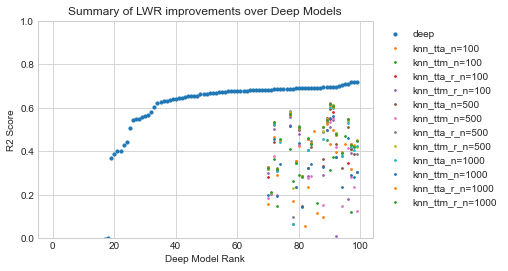

In [13]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [14]:
scores_df_base = scores_df[scores_df["predictor"]=='deep']
scores_df_uu = scores_df[scores_df["predictor"].str.contains('_uu')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_ut = scores_df[scores_df["predictor"].str.contains('_ut')] 
scores_df_tu = scores_df[scores_df["predictor"].str.contains('_tu')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_tta = scores_df[scores_df["predictor"].str.contains('_tta')] 
scores_df_ttm = scores_df[scores_df["predictor"].str.contains('_ttm')] 

NameError: name 'scores_df_tt' is not defined

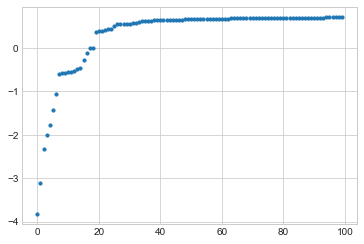

In [15]:
fig, ax = plt.subplots()
knn_models = scores_df_tta["predictor"].unique()
ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')
for knn_model in knn_models:
    subset = scores_df_tt[scores_df_tt["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_tta.png", bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
knn_models = scores_df_ttm["predictor"].unique()
ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')
for knn_model in knn_models:
    subset = scores_df_ttm[scores_df_ttm["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_ttm.png", bbox_inches='tight')
